## Classify RNA-Seq + ATAC-Seq by Cell type

In [133]:
# import needed modules:

# general python utilities
import os
import platform
import random
import shutil
import sys
import time
import datetime
import functools
import itertools as it
import copy

# recommended Python3 version >= 3.5
print('Python version: {}'.format(platform.sys.version))

# data-science & processing tools
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import h5py
import scanpy as sc
import anndata as ann

# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm

# plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
import tensorflow.keras as K

# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

Python version: 3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:05:27) 
[Clang 9.0.1 ]
TensorFlow version: 2.1.0

Imports Complete.


In [134]:
# make some fake data until real data becomes available
n_samples, n_rna_features, n_atac_features = 6000, 500, 100
rna_seq_fake = np.random.rand(n_samples, n_rna_features)
atac_seq_fake = np.random.rand(n_samples, n_atac_features)
X_np = np.concatenate([rna_seq_fake, atac_seq_fake], axis=1)
Y_np = np.array(['cell_type_A'] * 2000 + ['cell_type_B'] * 2000 + ['cell_type_C'] * 2000)

In [135]:
# make one-hot encoding of cell type classes
le = LabelEncoder()
Y_le = le.fit_transform(Y_np)
tf.one_hot(Y_le, depth=3)

<tf.Tensor: shape=(6000, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [136]:
''' Load in matrices generated after pre-processing steps '''
PATH = os.getcwd() # make sure cwd is 6_874-Multimodal-DL
OUTPUTS = os.path.join(PATH, 'Outputs')
atac_data_path = os.path.join(OUTPUTS, 'atacMatrix1')
rna_data_path = os.path.join(OUTPUTS, 'rnaMatrix1')
bimodal_data_path = os.path.join(OUTPUTS, 'bimodalEarlyFusionMatrix1')

# save as pandas dataframes
atac_df = pd.read_hdf(atac_data_path)
rna_df = pd.read_hdf(rna_data_path)
bimodal_df = pd.read_hdf(bimodal_data_path)

In [137]:
atac_df.head()

,sample,matrix,treatment_time,atac_1,atac_2,atac_4,atac_10,atac_17,atac_22,atac_24,...,atac_189594,atac_189595,atac_189596,atac_189597,atac_189598,atac_189599,atac_189600,atac_189601,atac_189602,atac_189603
0,sci-RNA-A-001.AAGTACGTTA,829,3,-0.29541,-0.015327,-0.015327,-0.015327,-0.015327,-0.02655,-0.015327,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327
1,sci-RNA-A-001.CGTATTGAGA,830,3,-0.29541,-0.015327,-0.015327,-0.015327,-0.015327,-0.02655,-0.015327,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327
2,sci-RNA-A-001.CGTCTATGAA,833,1,-0.29541,-0.015327,-0.015327,-0.015327,-0.015327,-0.02655,-0.015327,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327
3,sci-RNA-A-001.GACCAATGCG,828,0,-0.29541,-0.015327,-0.015327,-0.015327,-0.015327,-0.02655,-0.015327,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327
4,sci-RNA-A-001.TAGCCAGCAA,826,3,-0.29541,-0.015327,-0.015327,-0.015327,-0.015327,-0.02655,-0.015327,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327


**Observations**: 
- There are over 20,000 features, but only 3260 samples. Consider using PCA or another dimensionality reduction method before inputing into network
- This matrix is super sparse. Think about how to account for that (maybe in feature selection)
- TODO - feature selection

In [138]:
''' Get labels'''
Y_atac = atac_df['treatment_time']
Y_rna = rna_df['treatment_time']
Y_bimodal = bimodal_df['treatment_time_x']

In [139]:
''' Change to label-encoded values'''
le = LabelEncoder()
Y_atac_le = le.fit_transform(Y_atac) # note that this changes treatment time of 3 to 2, but other labels are the same
Y_rna_le = le.fit_transform(Y_rna)
Y_bimodal_le = le.fit_transform(Y_bimodal)

In [140]:
''' Get feature labels '''
# get features
atac_features = atac_df.loc[:, 'atac_1':].columns
rna_features = rna_df.loc[:, 'rna_2':].columns
bimodal_features = bimodal_df.loc[:, 'rna_2':].columns

# get number of features
n_atac_features = len(atac_features)
n_rna_features = len(rna_features)
n_bi_features = len(bimodal_features)

In [141]:
''' Make matrices into numpy arrays'''
X_atac_np = atac_df.loc[:, 'atac_1':].to_numpy()
X_rna_np = rna_df.loc[:, 'rna_2':].to_numpy()
X_bimodal_np = bimodal_df.loc[:, 'rna_2':].to_numpy()

In [166]:
''' Get training and test sets '''
# TODO - make sure these are stratified
X_train_atac, X_test_atac, Y_train_atac, Y_test_atac = train_test_split(X_atac_np, Y_atac_le, test_size=0.1, random_state=0)#, stratify=[0,1,2])
X_train_rna, X_test_rna, Y_train_rna, Y_test_rna = train_test_split(X_rna_np, Y_rna_le, test_size=0.1, random_state=0)#, stratify=[0,1,2])
X_train_bi, X_test_bi, Y_train_bi, Y_test_bi = train_test_split(X_bimodal_np, Y_bimodal_le, test_size=0.1, random_state=0)#,stratify=[0,1,2])

In [143]:
''' Make Y labels one-hot '''
# training sets
Y_atac_train = tf.one_hot(Y_train_atac, depth=3)
Y_rna_train = tf.one_hot(Y_train_rna, depth=3)
Y_bimodal_train = tf.one_hot(Y_train_bi, depth=3)

# test sets
Y_atac_test = tf.one_hot(Y_test_atac, depth=3)
Y_rna_test = tf.one_hot(Y_test_rna, depth=3)
Y_bimodal_test = tf.one_hot(Y_test_bi, depth=3)

In [144]:
''' Make matrices into TF tensors'''
# training sets
X_atac_train = tf.convert_to_tensor(X_train_atac)
X_rna_train = tf.convert_to_tensor(X_train_rna)
X_bimodal_train = tf.convert_to_tensor(X_train_bi)

# test sets
X_atac_test = tf.convert_to_tensor(X_test_atac)
X_rna_test = tf.convert_to_tensor(X_test_rna)
X_bimodal_test = tf.convert_to_tensor(X_test_bi)

In [145]:
bimodal_df.head()

,sample,matrix_x,treatment_time_x,rna_2,rna_8,rna_11,rna_12,rna_15,rna_18,rna_20,...,atac_189594,atac_189595,atac_189596,atac_189597,atac_189598,atac_189599,atac_189600,atac_189601,atac_189602,atac_189603
0,sci-RNA-A-001.AAGTACGTTA,2,3,-0.015289,-0.03421,-0.033936,-0.03125,-0.015289,-0.071228,-0.021637,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327
1,sci-RNA-A-001.CGTATTGAGA,16,3,-0.015289,-0.03421,-0.033936,-0.03125,-0.015289,-0.071228,-0.021637,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327
2,sci-RNA-A-001.CGTCTATGAA,8,1,-0.015289,-0.03421,-0.033936,-0.03125,-0.015289,-0.071228,-0.021637,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327
3,sci-RNA-A-001.GACCAATGCG,15,0,-0.015289,-0.03421,-0.033936,-0.03125,-0.015289,-0.071228,-0.021637,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327
4,sci-RNA-A-001.TAGCCAGCAA,12,3,-0.015289,-0.03421,-0.033936,-0.03125,-0.015289,-0.071228,-0.021637,...,-0.02655,-0.049408,-0.018692,-0.031647,-0.048462,-0.02504,-0.032776,-0.02504,-0.029755,-0.015327


In [70]:
''' Try plotting with UMAP (later)'''
''' Create AnnData object'''
def create_AnnData_from_df(df, obs='treatment_time', label_cutoff_ix=5):
    '''
        @params:
        Given spectra df, creates AnnData matrix
        label_cutoff_ix: columns index where spectral data begins
        
        @returns: annData object
    '''
    obs_nonspatial = pd.DataFrame(df[obs])
    var_nonspatial = pd.DataFrame(df.iloc[:,label_cutoff_ix:].columns)
    signal = df.iloc[:,label_cutoff_ix:].to_numpy()
    ann_df = ann.AnnData(X=signal)
    
    # change variable and observation names
    ann_df.obs = obs_nonspatial
    ann_df.var = var_nonspatial
    
    return ann_df

In [108]:
atac_df['treatment_time'] = list(map(str, atac_df['treatment_time']))

In [112]:
rna_df['treatment_time'] = list(map(str, rna_df['treatment_time']))

In [113]:
bimodal_df['treatment_time_x'] = list(map(str, bimodal_df['treatment_time_x']))

In [119]:
''' Create AnnData objects'''
ann_atac = create_AnnData_from_df(atac_df, obs='treatment_time', label_cutoff_ix=3)
ann_rna = create_AnnData_from_df(rna_df, obs='treatment_time', label_cutoff_ix=3)
ann_bimodal = create_AnnData_from_df(bimodal_df, obs='treatment_time_x', label_cutoff_ix=3)

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 
AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 
AnnData expects string indices for some functionality, but your first two indices are: RangeIndex(start=0, stop=2, step=1). 


In [120]:
def UMAP(df):
    sc.tl.pca(df)
    # sc.pl.pca(df, color='day')
    # sc.pl.pca_variance_ratio(df, log=True)
    sc.pp.neighbors(df)
    sc.tl.umap(df)

In [121]:
UMAP(ann_atac)

In [122]:
UMAP(ann_rna)

In [123]:
UMAP(ann_bimodal)

... storing 'treatment_time' as categorical


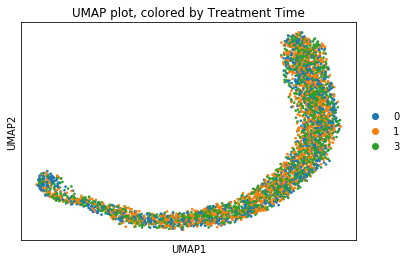

... storing 'treatment_time' as categorical


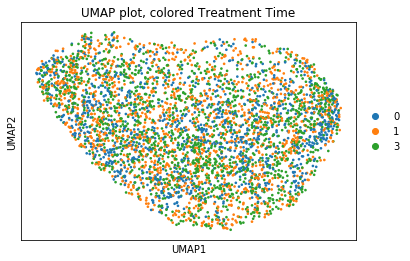

... storing 'treatment_time_x' as categorical


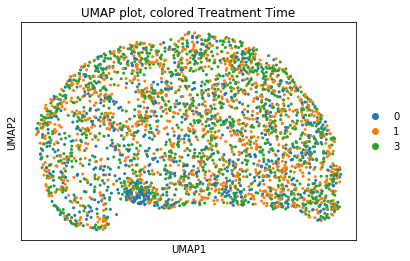

In [124]:
''' Plot UMAPs'''
sc.pl.umap(ann_atac, color=['treatment_time'], 
              title=['UMAP plot, colored by Treatment Time'],)
              # palette='Purples')

sc.pl.umap(ann_rna, color=['treatment_time'], 
              title=['UMAP plot, colored Treatment Time'])
              #palette='Purples')
    
sc.pl.umap(ann_bimodal, color=['treatment_time_x'], 
            title=['UMAP plot, colored Treatment Time'])
              #palette='Purples')

In [127]:
atac_df['treatment_time'].value_counts()

3    1578
1    1500
0    1180
Name: treatment_time, dtype: int64

In [128]:
rna_df['treatment_time'].value_counts()

3    1609
1    1491
0    1177
Name: treatment_time, dtype: int64

In [131]:
bimodal_df['treatment_time_x'].value_counts()

3    1342
1    1216
0     702
Name: treatment_time_x, dtype: int64

In [268]:
''' Define architecture '''
HIDDEN_LAYER_DIMS = [500, 500, 2000]
OUTPUT_DIM = 3

def nn_model(n_features, dropout_rate, l2_lambda):
    """
    Returns a tf.keras.Model for cell-type classification with the specifications 
    listed above.
    
    Arguments:
      n_features: the number of features of the datapoints used
        as input to the model (used to determine the input shape)
      dropout_rate: the dropout rate of the dropout layers
      l2_lambda: the weight of the L2 regularization penalty on the
        weights (but not the biases) of the model
    
    Returns:
      model: a tf.keras.Model for tSNE with the specifications
        listed above
    """
    model = K.Sequential()
    
    
    l2_reg = tf.keras.regularizers.l2(l=l2_lambda)
    ######################## BEGIN YOUR ANSWER ########################
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[0], batch_input_shape=(None, n_features), 
                                    activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[1], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(HIDDEN_LAYER_DIMS[2], batch_input_shape=(None, n_features),
                                   activation='relu', kernel_regularizer=l2_reg))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    model.add(tf.keras.layers.Dense(OUTPUT_DIM, batch_input_shape=(None, n_features),
                                   activation=tf.nn.softmax, kernel_regularizer=l2_reg))
    
    ######################### END YOUR ANSWER #########################
    
    return model

In [269]:
''' Give summary of architecture '''
model = nn_model(n_features, dropout_rate=dropout_rate, l2_lambda=l2_lambda)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 500)               300500    
_________________________________________________________________
dropout_24 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_25 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 2000)              1002000   
_________________________________________________________________
dropout_26 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)                

In [298]:
def sample_shuffle_data(arrays, n_samples=None):
    """subsamples examples from a list of datasets
    
    samples `n_samples` without replacement from along the first dimension
    of each array in `arrays`. The same first-dimension slices are 
    selected for each array in `arrays`.
    
    Arguments:
      arrays: the arrays to be sliced, all must have the same size along 
        their first dimension.
      n_samples: (None) the number of samples to be selected, `n_samples` must 
        be less than or equal to the length of the arrays. If n_samples it not
        passed or is `None`. Then each array in `arrays` will be 
        shuffled in the same way and returned.
      
    Returns:
      sampled: a `tuple` of len the same as `len(arrays)` where each
        element is an array of len `n_samples`
    """
    batch_len = arrays[0].shape[0]
    n_samples = batch_len if n_samples is None else n_samples

    err_msg = 'all arrays must have the same size along their first dimension'
    assert all(batch_len == x.shape[0] for x in arrays), err_msg 
    err_msg = 'n cannot be greater then the length of the arrays'
    assert n_samples <= batch_len, err_msg

    sampling_idxs = tf.random.shuffle(tf.range(batch_len))[:n_samples]
    sampled = tuple(tf.gather(x, sampling_idxs, axis=0) for x in arrays)
    
    return sampled

In [280]:
''' Train step '''
def train_step(model, loss, optimizer, x_batch, y_batch):
    """
    Performs one training step on a model given a loss, optimizer, inputs,
    and labels.
    
    Arguments:
      model: the model on which the pass will be performed
      loss: the loss function to be evaluated, from which the gradients will be
        computed
      optimizer: a `tf.optimizers` object defining the optimization scheme
      x_batch: model training inputs
      y_batch: model training labels
      
    Returns:
      loss_value: the computed loss for the forward training pass
    """
#     print('X_batch : {} \n y_batch : {}'.format(x_batch, y_batch))
    with tf.GradientTape() as tape:
#         print(f'x_batch: {x_batch}')
#         print(f'y_batch: {y_batch}')

        y_batch_pred = model(x_batch, training=True)
        loss_value = loss(y_batch, y_batch_pred)
#         print(f"model losses type: {model.losses}")
        loss_value += sum(model.losses)
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss_value

In [319]:
''' Training Loop '''
def training(x_train, y_train, x_val, y_val, hyperparam_config, num_epochs, batch_size,
             save_model=True, model_dir='models/best_model'):  
    
    """
    Train a fully-connected network to classify rna_seq + atac-seq by cell type
    
    Arguments:
      x_train: input training set
      y_train: label training set
      x_val: input validation set
      y_val: label validation set
      hyperparam_config: a dictionary that stores a hyperparameter configuration,
                         including:
                           - "dropout_rate": dropout rate (1 - keep probability),
                           - "l2": coefficient lambda for L2 regularization,
                           - "lr": learning rate for RMSProp optimizer
      num_epochs: number of epochs to train
      batch_size: training mini-batch size (must be same as the batch size for pairwise P calculation)
      save_model: whether or not to save the best model based on the validation loss
      model_dir: location where model will be saved
    
    Returns:
      best_loss: best validation loss
      best_kl_div: validation KL loss from the epoch that has best validation loss
    """
    
    ################################################################################
    # Make sure to wrap train_step with tf.function to speed up training!
    train_fn = tf.function(train_step)
#     train_fn = train_step
    ################################################################################ 
    
    ######################## BEGIN YOUR ANSWER ########################
    # get num_batches
    num_samples, num_features = x_train.shape
    num_batches = np.floor(num_samples) // batch_size
    
    # initalize model, loss, and optimizers
    dropout_rate = hyperparam_config['dropout_rate']
    l2_lambda = hyperparam_config['l2_lambda']
    lr = hyperparam_config['lr']
    model = nn_model(n_features=num_features, dropout_rate=dropout_rate, l2_lambda=l2_lambda)
    loss_fn = tf.keras.losses.CategoricalCrossentropy() # todo - make sure this is correct
    optimizer = K.optimizers.SGD(learning_rate=lr)  #TODO - double check this optimizer

    
    # Get initial loss for comparison 
    print('getting initial loss')
    best_loss = loss_fn(y_val, model(x_val))
    
    # init progress bars
    epoch_pbar = tqdm(total=num_epochs, desc="Training Epochs")
    batch_pbar = tqdm(desc="Training Steps")
    
    
    n = x_train.shape[0]
    # for each epoch   
    # start training loop 
    for epoch in range(num_epochs):
        # shuffle data
        if epoch >= 1: x_train, y_train = sample_shuffle_data([x_train, y_train], num_samples)
        
        batch_pbar.reset(num_batches)
        for step in range(int(num_batches)):
            # getting indices of batches to train on
            range_begin = (step * batch_size) % (x_train.shape[0] - batch_size) #taking mod to prevent ix errors
            range_end = range_begin + batch_size
            batch_x = x_train[range_begin:range_end, :]
            batch_y = y_train[range_begin:range_end, :]
            epoch_loss = train_fn(model, loss_fn, optimizer,
                                 batch_x, batch_y)
  
            
            batch_pbar.update()
    
        # compute and print loss on validation data
        val_loss = loss_fn(y_val, model(x_val)) #note - don't need reg_coeff defined because already defined using functools.partial

        tf.print("epoch: {:02d}, loss: {:5.3f}".format(epoch + 1, val_loss))
        
        if val_loss < best_loss:
            best_loss = val_loss
            if save_model:
                # if directory hasn't been created, create it
                if not os.path.isdir('models'):
                    !mkdir -p models
                # if model has already been saved, remove folder and save again
                if os.path.isdir(model_dir):
                    shutil.rmtree(model_dir)
                # make directory again and save
#                 !mkdir -p models/best_loss
                model.save(model_dir)
        batch_pbar.refresh()
        epoch_pbar.update()
            
                
    ######################### END YOUR ANSWER #########################
    
    
    return best_loss


In [300]:
''' Get useful parameters for defining architecture '''
X_shape = tf.shape(X_bimodal_train)
assert len(X_shape) == 2, f'Order of input tensor shoud be 2 but is {len(X_shape)}'
num_cells, num_features = X_shape
dropout_rate = 0.1
l2_lambda = 1e-6
learning_rate = 0.001

In [301]:
Y_atac_test

<tf.Tensor: shape=(426, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [306]:
n_epochs = 50

In [307]:
''' Train model using ATAC-seq as features'''
# define hyperparameters
hyperparams_atac = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}


training(X_atac_train, Y_atac_train, X_atac_test, Y_atac_test, 
         hyperparam_config=hyperparams_atac,
        num_epochs=n_epochs,
        batch_size=100,
        save_model=True,
        model_dir=f'models/atac_only_model_{n_epochs}_epochs')

getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.121
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 02, loss: 1.118
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 03, loss: 1.116
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 04, loss: 1.116
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 05, loss: 1.113
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 06, loss: 1.112
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 07, loss: 1.112
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 08, loss: 1.111
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 09, loss: 1.111
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 10, loss: 1.110
INFO:tensorflow:Assets written to: models/atac_only_model_50_epochs/assets
epoch: 11, loss: 1.1

<tf.Tensor: shape=(), dtype=float32, numpy=1.1101297>

In [308]:
''' Train model using RNA-seq as features'''
# define hyperparameters
hyperparams_rna = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}

training(X_rna_train, Y_rna_train, X_rna_test, Y_rna_test, 
         hyperparam_config=hyperparams_rna,
        num_epochs=50,
        batch_size=100,
        save_model=True,
        model_dir=f'models/rna_only_model_{n_epochs}_epochs')

getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.116
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 02, loss: 1.109
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 03, loss: 1.104
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 04, loss: 1.097
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 05, loss: 1.095
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 06, loss: 1.089
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 07, loss: 1.085
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 08, loss: 1.078
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 09, loss: 1.074
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 10, loss: 1.068
INFO:tensorflow:Assets written to: models/rna_only_model_50_epochs/assets
epoch: 11, loss: 1.064
INFO:te

<tf.Tensor: shape=(), dtype=float32, numpy=0.8293294>

In [309]:
''' Train model using both ATAC and RNA as features'''
# define hyperparameters
hyperparams_bimodal = {'dropout_rate':0.1, 'lr': 0.001, 'l2_lambda': l2_lambda}

training(X_bimodal_train, Y_bimodal_train, X_bimodal_test, Y_bimodal_test, 
         hyperparam_config=hyperparams_bimodal,
        num_epochs=50,
        batch_size=100,
        save_model=True,
        model_dir=f'models/bimodal_model_{n_epochs}_epochs')

getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.102
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 02, loss: 1.094
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 03, loss: 1.089
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 04, loss: 1.083
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 05, loss: 1.078
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 06, loss: 1.073
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 07, loss: 1.069
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 08, loss: 1.065
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 09, loss: 1.062
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 10, loss: 1.058
INFO:tensorflow:Assets written to: models/bimodal_model_50_epochs/assets
epoch: 11, loss: 1.053
INFO:tensorflow:A

<tf.Tensor: shape=(), dtype=float32, numpy=0.9919035>

## Hyperparameter tuning

In [320]:
''' Hyperparameter search using validation set'''
def grid_search(x_train, y_train, dropout_rates, l2_lambdas, learning_rates, num_epochs=40, batch_size=300):
    """
    Perform grid search for the best tSNE hyperparameters
    
    Arguments:
      x_train: input training set
      y_train: label training set
      dropout_rates: dropout rates to try
      l2_lambdas: L2 lambda coefficients to try
      learning_rates: learning rates to try
      num_epochs: number of epochs to train
      batch_size: training mini-batch size
    
    Returns:
      losses: list losses for configurations tested where
        losses[i] = [dropout_rate, l2_lambda, learning_rate, best_loss, best_kl_divgergence]
    """
    losses = []
    
    pbar = tqdm(total = len(dropout_rates) * len(l2_lambdas) * len(learning_rates))
    for dropout_rate in dropout_rates:
        for l2_lambda in l2_lambdas:
            for learning_rate in learning_rates:
                print("training with dropout:{} l2:{} lr:{}".format(dropout_rate,l2_lambda,learning_rate))
                # DO NOT shuffle your validation/train set because the pairwise label are calculated by batch
                # Use the last batch in train set as the validation set
                subset_x_train, subset_y_train=(x_train[0:-batch_size],y_train[0:-batch_size])
                subset_x_val, subset_y_val = (x_train[-batch_size:],y_train[-batch_size:])
                hyperparam_config = {'dropout_rate': dropout_rate,
                                     'l2_lambda': l2_lambda,
                                     'lr': learning_rate}

                best_loss = training(subset_x_train, subset_y_train,
                                     subset_x_val, subset_y_val,
                                     hyperparam_config,
                                     num_epochs,
                                     batch_size,
                                     save_model=False)

                losses.append([dropout_rate, l2_lambda, learning_rate, best_loss])
                pbar.update(1)
    pbar.close()
    return losses


In [321]:
dropout_rates = [0.5, 0.2, 0.1]
l2_lambdas = [1e-03, 1e-06, 0]
learning_rates = [0.1, 0.01, 1e-3, 1e-4]
NUM_EPOCHS = 10
BATCH_SIZE = 400

In [322]:
''' GRID-SEARCH for ATAC-seq as input'''
atac_param_result = grid_search(X_atac_train, Y_atac_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.5 l2:0.001 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.104
epoch: 02, loss: 1.094
epoch: 03, loss: 1.067
epoch: 04, loss: 1.053
epoch: 05, loss: 1.015
epoch: 06, loss: 1.002
epoch: 07, loss: 0.965
epoch: 08, loss: 0.964
epoch: 09, loss: 0.933
epoch: 10, loss: 0.953
training with dropout:0.5 l2:0.001 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.124
epoch: 02, loss: 1.117
epoch: 03, loss: 1.108
epoch: 04, loss: 1.106
epoch: 05, loss: 1.108
epoch: 06, loss: 1.102
epoch: 07, loss: 1.099
epoch: 08, loss: 1.097
epoch: 09, loss: 1.094
epoch: 10, loss: 1.088
training with dropout:0.5 l2:0.001 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.130
epoch: 02, loss: 1.134
epoch: 03, loss: 1.137
epoch: 04, loss: 1.139
epoch: 05, loss: 1.137
epoch: 06, loss: 1.138
epoch: 07, loss: 1.139
epoch: 08, loss: 1.139
epoch: 09, loss: 1.136
epoch: 10, loss: 1.135
training with dropout:0.5 l2:0.001 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.126
epoch: 02, loss: 1.124
epoch: 03, loss: 1.123
epoch: 04, loss: 1.122
epoch: 05, loss: 1.121
epoch: 06, loss: 1.120
epoch: 07, loss: 1.119
epoch: 08, loss: 1.118
epoch: 09, loss: 1.117
epoch: 10, loss: 1.117
training with dropout:0.5 l2:1e-06 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.110
epoch: 02, loss: 1.112
epoch: 03, loss: 1.153
epoch: 04, loss: 1.047
epoch: 05, loss: 1.048
epoch: 06, loss: 1.009
epoch: 07, loss: 0.974
epoch: 08, loss: 0.967
epoch: 09, loss: 0.965
epoch: 10, loss: 0.969
training with dropout:0.5 l2:1e-06 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.136
epoch: 02, loss: 1.126
epoch: 03, loss: 1.124
epoch: 04, loss: 1.123
epoch: 05, loss: 1.111
epoch: 06, loss: 1.112
epoch: 07, loss: 1.108
epoch: 08, loss: 1.106
epoch: 09, loss: 1.103
epoch: 10, loss: 1.103
training with dropout:0.5 l2:1e-06 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.139
epoch: 02, loss: 1.135
epoch: 03, loss: 1.139
epoch: 04, loss: 1.139
epoch: 05, loss: 1.139
epoch: 06, loss: 1.138
epoch: 07, loss: 1.138
epoch: 08, loss: 1.138
epoch: 09, loss: 1.135
epoch: 10, loss: 1.132
training with dropout:0.5 l2:1e-06 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.121
epoch: 02, loss: 1.120
epoch: 03, loss: 1.120
epoch: 04, loss: 1.119
epoch: 05, loss: 1.119
epoch: 06, loss: 1.119
epoch: 07, loss: 1.118
epoch: 08, loss: 1.118
epoch: 09, loss: 1.118
epoch: 10, loss: 1.117
training with dropout:0.5 l2:0 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.161
epoch: 02, loss: 1.143
epoch: 03, loss: 1.061
epoch: 04, loss: 1.056
epoch: 05, loss: 1.036
epoch: 06, loss: 0.987
epoch: 07, loss: 0.956
epoch: 08, loss: 0.934
epoch: 09, loss: 0.934
epoch: 10, loss: 0.914
training with dropout:0.5 l2:0 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.108
epoch: 02, loss: 1.105
epoch: 03, loss: 1.097
epoch: 04, loss: 1.094
epoch: 05, loss: 1.094
epoch: 06, loss: 1.083
epoch: 07, loss: 1.082
epoch: 08, loss: 1.082
epoch: 09, loss: 1.073
epoch: 10, loss: 1.075
training with dropout:0.5 l2:0 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.153
epoch: 02, loss: 1.126
epoch: 03, loss: 1.121
epoch: 04, loss: 1.121
epoch: 05, loss: 1.121
epoch: 06, loss: 1.120
epoch: 07, loss: 1.120
epoch: 08, loss: 1.118
epoch: 09, loss: 1.117
epoch: 10, loss: 1.117
training with dropout:0.5 l2:0 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.114
epoch: 02, loss: 1.112
epoch: 03, loss: 1.110
epoch: 04, loss: 1.109
epoch: 05, loss: 1.107
epoch: 06, loss: 1.106
epoch: 07, loss: 1.105
epoch: 08, loss: 1.105
epoch: 09, loss: 1.104
epoch: 10, loss: 1.103
training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.139
epoch: 02, loss: 1.181
epoch: 03, loss: 1.015
epoch: 04, loss: 1.020
epoch: 05, loss: 1.024
epoch: 06, loss: 1.029
epoch: 07, loss: 1.037
epoch: 08, loss: 1.038
epoch: 09, loss: 1.045
epoch: 10, loss: 1.049
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.113
epoch: 02, loss: 1.109
epoch: 03, loss: 1.105
epoch: 04, loss: 1.105
epoch: 05, loss: 1.103
epoch: 06, loss: 1.098
epoch: 07, loss: 1.107
epoch: 08, loss: 1.100
epoch: 09, loss: 1.102
epoch: 10, loss: 1.100
training with dropout:0.2 l2:0.001 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.129
epoch: 02, loss: 1.115
epoch: 03, loss: 1.114
epoch: 04, loss: 1.114
epoch: 05, loss: 1.115
epoch: 06, loss: 1.115
epoch: 07, loss: 1.116
epoch: 08, loss: 1.116
epoch: 09, loss: 1.116
epoch: 10, loss: 1.115
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.176
epoch: 02, loss: 1.171
epoch: 03, loss: 1.167
epoch: 04, loss: 1.163
epoch: 05, loss: 1.159
epoch: 06, loss: 1.156
epoch: 07, loss: 1.153
epoch: 08, loss: 1.151
epoch: 09, loss: 1.148
epoch: 10, loss: 1.147
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.126
epoch: 02, loss: 1.105
epoch: 03, loss: 1.026
epoch: 04, loss: 1.027
epoch: 05, loss: 1.043
epoch: 06, loss: 1.061
epoch: 07, loss: 1.076
epoch: 08, loss: 1.081
epoch: 09, loss: 1.088
epoch: 10, loss: 1.091
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.110
epoch: 02, loss: 1.110
epoch: 03, loss: 1.105
epoch: 04, loss: 1.105
epoch: 05, loss: 1.101
epoch: 06, loss: 1.109
epoch: 07, loss: 1.097
epoch: 08, loss: 1.102
epoch: 09, loss: 1.108
epoch: 10, loss: 1.106
training with dropout:0.2 l2:1e-06 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.179
epoch: 02, loss: 1.162
epoch: 03, loss: 1.155
epoch: 04, loss: 1.151
epoch: 05, loss: 1.150
epoch: 06, loss: 1.149
epoch: 07, loss: 1.148
epoch: 08, loss: 1.147
epoch: 09, loss: 1.146
epoch: 10, loss: 1.144
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.147
epoch: 02, loss: 1.145
epoch: 03, loss: 1.144
epoch: 04, loss: 1.142
epoch: 05, loss: 1.141
epoch: 06, loss: 1.141
epoch: 07, loss: 1.140
epoch: 08, loss: 1.139
epoch: 09, loss: 1.139
epoch: 10, loss: 1.139
training with dropout:0.2 l2:0 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.082
epoch: 02, loss: 1.056
epoch: 03, loss: 1.048
epoch: 04, loss: 1.042
epoch: 05, loss: 1.045
epoch: 06, loss: 1.061
epoch: 07, loss: 1.075
epoch: 08, loss: 1.083
epoch: 09, loss: 1.078
epoch: 10, loss: 1.090
training with dropout:0.2 l2:0 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.138
epoch: 02, loss: 1.137
epoch: 03, loss: 1.134
epoch: 04, loss: 1.130
epoch: 05, loss: 1.135
epoch: 06, loss: 1.130
epoch: 07, loss: 1.136
epoch: 08, loss: 1.142
epoch: 09, loss: 1.145
epoch: 10, loss: 1.151
training with dropout:0.2 l2:0 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.193
epoch: 02, loss: 1.168
epoch: 03, loss: 1.158
epoch: 04, loss: 1.154
epoch: 05, loss: 1.152
epoch: 06, loss: 1.151
epoch: 07, loss: 1.150
epoch: 08, loss: 1.148
epoch: 09, loss: 1.149
epoch: 10, loss: 1.148
training with dropout:0.2 l2:0 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.138
epoch: 02, loss: 1.137
epoch: 03, loss: 1.136
epoch: 04, loss: 1.135
epoch: 05, loss: 1.134
epoch: 06, loss: 1.133
epoch: 07, loss: 1.133
epoch: 08, loss: 1.132
epoch: 09, loss: 1.131
epoch: 10, loss: 1.131
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.111
epoch: 02, loss: 1.051
epoch: 03, loss: 1.059
epoch: 04, loss: 1.034
epoch: 05, loss: 1.051
epoch: 06, loss: 1.052
epoch: 07, loss: 1.063
epoch: 08, loss: 1.069
epoch: 09, loss: 1.074
epoch: 10, loss: 1.080
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.122
epoch: 02, loss: 1.115
epoch: 03, loss: 1.118
epoch: 04, loss: 1.125
epoch: 05, loss: 1.115
epoch: 06, loss: 1.114
epoch: 07, loss: 1.118
epoch: 08, loss: 1.115
epoch: 09, loss: 1.119
epoch: 10, loss: 1.122
training with dropout:0.1 l2:0.001 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.125
epoch: 02, loss: 1.114
epoch: 03, loss: 1.109
epoch: 04, loss: 1.107
epoch: 05, loss: 1.105
epoch: 06, loss: 1.104
epoch: 07, loss: 1.104
epoch: 08, loss: 1.103
epoch: 09, loss: 1.102
epoch: 10, loss: 1.102
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.195
epoch: 02, loss: 1.192
epoch: 03, loss: 1.189
epoch: 04, loss: 1.185
epoch: 05, loss: 1.182
epoch: 06, loss: 1.180
epoch: 07, loss: 1.177
epoch: 08, loss: 1.175
epoch: 09, loss: 1.172
epoch: 10, loss: 1.170
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.211
epoch: 02, loss: 1.050
epoch: 03, loss: 1.013
epoch: 04, loss: 1.020
epoch: 05, loss: 1.024
epoch: 06, loss: 1.027
epoch: 07, loss: 1.040
epoch: 08, loss: 1.047
epoch: 09, loss: 1.052
epoch: 10, loss: 1.058
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.126
epoch: 02, loss: 1.126
epoch: 03, loss: 1.124
epoch: 04, loss: 1.121
epoch: 05, loss: 1.123
epoch: 06, loss: 1.126
epoch: 07, loss: 1.131
epoch: 08, loss: 1.128
epoch: 09, loss: 1.134
epoch: 10, loss: 1.137
training with dropout:0.1 l2:1e-06 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.111
epoch: 02, loss: 1.110
epoch: 03, loss: 1.110
epoch: 04, loss: 1.109
epoch: 05, loss: 1.109
epoch: 06, loss: 1.109
epoch: 07, loss: 1.109
epoch: 08, loss: 1.108
epoch: 09, loss: 1.107
epoch: 10, loss: 1.107
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.111
epoch: 02, loss: 1.109
epoch: 03, loss: 1.107
epoch: 04, loss: 1.105
epoch: 05, loss: 1.103
epoch: 06, loss: 1.102
epoch: 07, loss: 1.101
epoch: 08, loss: 1.100
epoch: 09, loss: 1.099
epoch: 10, loss: 1.098
training with dropout:0.1 l2:0 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.087
epoch: 02, loss: 1.068
epoch: 03, loss: 1.057
epoch: 04, loss: 1.058
epoch: 05, loss: 1.077
epoch: 06, loss: 1.092
epoch: 07, loss: 1.107
epoch: 08, loss: 1.119
epoch: 09, loss: 1.128
epoch: 10, loss: 1.139
training with dropout:0.1 l2:0 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.118
epoch: 02, loss: 1.119
epoch: 03, loss: 1.111
epoch: 04, loss: 1.115
epoch: 05, loss: 1.112
epoch: 06, loss: 1.118
epoch: 07, loss: 1.116
epoch: 08, loss: 1.113
epoch: 09, loss: 1.117
epoch: 10, loss: 1.123
training with dropout:0.1 l2:0 lr:0.001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.135
epoch: 02, loss: 1.128
epoch: 03, loss: 1.125
epoch: 04, loss: 1.123
epoch: 05, loss: 1.121
epoch: 06, loss: 1.120
epoch: 07, loss: 1.119
epoch: 08, loss: 1.118
epoch: 09, loss: 1.118
epoch: 10, loss: 1.117
training with dropout:0.1 l2:0 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.221
epoch: 02, loss: 1.214
epoch: 03, loss: 1.209
epoch: 04, loss: 1.203
epoch: 05, loss: 1.199
epoch: 06, loss: 1.194
epoch: 07, loss: 1.190
epoch: 08, loss: 1.186
epoch: 09, loss: 1.182
epoch: 10, loss: 1.179



In [362]:
''' GRID-SEARCH with RNA-seq as input'''
dropout_rates = [0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
rna_param_result = grid_search(X_rna_train, Y_rna_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, BATCH_SIZE)

training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.075
epoch: 02, loss: 1.036
epoch: 03, loss: 0.931
epoch: 04, loss: 0.825
epoch: 05, loss: 0.777
epoch: 06, loss: 0.742
epoch: 07, loss: 0.731
epoch: 08, loss: 0.726
epoch: 09, loss: 0.719
epoch: 10, loss: 0.717
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.103
epoch: 02, loss: 1.099
epoch: 03, loss: 1.087
epoch: 04, loss: 1.087
epoch: 05, loss: 1.078
epoch: 06, loss: 1.063
epoch: 07, loss: 1.060
epoch: 08, loss: 1.053
epoch: 09, loss: 1.033
epoch: 10, loss: 1.026
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.099
epoch: 02, loss: 1.099
epoch: 03, loss: 1.100
epoch: 04, loss: 1.100
epoch: 05, loss: 1.100
epoch: 06, loss: 1.100
epoch: 07, loss: 1.100
epoch: 08, loss: 1.100
epoch: 09, loss: 1.100
epoch: 10, loss: 1.100
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.060
epoch: 02, loss: 1.035
epoch: 03, loss: 0.845
epoch: 04, loss: 0.751
epoch: 05, loss: 0.686
epoch: 06, loss: 0.662
epoch: 07, loss: 0.649
epoch: 08, loss: 0.634
epoch: 09, loss: 0.631
epoch: 10, loss: 0.628
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.088
epoch: 02, loss: 1.074
epoch: 03, loss: 1.070
epoch: 04, loss: 1.058
epoch: 05, loss: 1.047
epoch: 06, loss: 1.034
epoch: 07, loss: 1.019
epoch: 08, loss: 1.004
epoch: 09, loss: 0.988
epoch: 10, loss: 0.976
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.219
epoch: 02, loss: 1.212
epoch: 03, loss: 1.206
epoch: 04, loss: 1.200
epoch: 05, loss: 1.194
epoch: 06, loss: 1.189
epoch: 07, loss: 1.185
epoch: 08, loss: 1.181
epoch: 09, loss: 1.177
epoch: 10, loss: 1.174
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.039
epoch: 02, loss: 0.957
epoch: 03, loss: 0.838
epoch: 04, loss: 0.726
epoch: 05, loss: 0.682
epoch: 06, loss: 0.661
epoch: 07, loss: 0.651
epoch: 08, loss: 0.643
epoch: 09, loss: 0.638
epoch: 10, loss: 0.632
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.113
epoch: 02, loss: 1.102
epoch: 03, loss: 1.091
epoch: 04, loss: 1.083
epoch: 05, loss: 1.070
epoch: 06, loss: 1.059
epoch: 07, loss: 1.053
epoch: 08, loss: 1.033
epoch: 09, loss: 1.021
epoch: 10, loss: 1.005
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.099
epoch: 02, loss: 1.099
epoch: 03, loss: 1.099
epoch: 04, loss: 1.098
epoch: 05, loss: 1.098
epoch: 06, loss: 1.098
epoch: 07, loss: 1.098
epoch: 08, loss: 1.097
epoch: 09, loss: 1.097
epoch: 10, loss: 1.097
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.065
epoch: 02, loss: 1.012
epoch: 03, loss: 0.923
epoch: 04, loss: 0.813
epoch: 05, loss: 0.768
epoch: 06, loss: 0.744
epoch: 07, loss: 0.734
epoch: 08, loss: 0.727
epoch: 09, loss: 0.721
epoch: 10, loss: 0.719
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.121
epoch: 02, loss: 1.116
epoch: 03, loss: 1.104
epoch: 04, loss: 1.091
epoch: 05, loss: 1.084
epoch: 06, loss: 1.067
epoch: 07, loss: 1.059
epoch: 08, loss: 1.043
epoch: 09, loss: 1.030
epoch: 10, loss: 1.018
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.197
epoch: 02, loss: 1.188
epoch: 03, loss: 1.180
epoch: 04, loss: 1.172
epoch: 05, loss: 1.166
epoch: 06, loss: 1.160
epoch: 07, loss: 1.155
epoch: 08, loss: 1.150
epoch: 09, loss: 1.146
epoch: 10, loss: 1.142



In [363]:
''' GRID-SEARCH with bimodal input '''
dropout_rates = [0.2, 0.1]
l2_lambdas = [1e-03, 1e-06]
learning_rates = [0.1, 0.01, 1e-4]
bimodal_param_result = grid_search(X_bimodal_train, Y_bimodal_train, dropout_rates, l2_lambdas, learning_rates, NUM_EPOCHS, 300)

training with dropout:0.2 l2:0.001 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.064
epoch: 02, loss: 1.037
epoch: 03, loss: 0.823
epoch: 04, loss: 0.807
epoch: 05, loss: 0.796
epoch: 06, loss: 0.788
epoch: 07, loss: 0.797
epoch: 08, loss: 0.790
epoch: 09, loss: 0.784
epoch: 10, loss: 0.785
training with dropout:0.2 l2:0.001 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.092
epoch: 02, loss: 1.062
epoch: 03, loss: 1.046
epoch: 04, loss: 1.043
epoch: 05, loss: 1.025
epoch: 06, loss: 1.014
epoch: 07, loss: 1.005
epoch: 08, loss: 0.998
epoch: 09, loss: 0.989
epoch: 10, loss: 0.982
training with dropout:0.2 l2:0.001 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.139
epoch: 02, loss: 1.135
epoch: 03, loss: 1.131
epoch: 04, loss: 1.128
epoch: 05, loss: 1.125
epoch: 06, loss: 1.122
epoch: 07, loss: 1.120
epoch: 08, loss: 1.118
epoch: 09, loss: 1.116
epoch: 10, loss: 1.114
training with dropout:0.2 l2:1e-06 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.122
epoch: 02, loss: 0.903
epoch: 03, loss: 0.806
epoch: 04, loss: 0.767
epoch: 05, loss: 0.758
epoch: 06, loss: 0.750
epoch: 07, loss: 0.747
epoch: 08, loss: 0.745
epoch: 09, loss: 0.742
epoch: 10, loss: 0.740
training with dropout:0.2 l2:1e-06 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.086
epoch: 02, loss: 1.063
epoch: 03, loss: 1.048
epoch: 04, loss: 1.041
epoch: 05, loss: 1.027
epoch: 06, loss: 1.018
epoch: 07, loss: 1.011
epoch: 08, loss: 1.004
epoch: 09, loss: 0.998
epoch: 10, loss: 0.994
training with dropout:0.2 l2:1e-06 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.103
epoch: 02, loss: 1.102
epoch: 03, loss: 1.101
epoch: 04, loss: 1.101
epoch: 05, loss: 1.100
epoch: 06, loss: 1.099
epoch: 07, loss: 1.099
epoch: 08, loss: 1.098
epoch: 09, loss: 1.098
epoch: 10, loss: 1.097
training with dropout:0.1 l2:0.001 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.025
epoch: 02, loss: 0.966
epoch: 03, loss: 0.873
epoch: 04, loss: 0.864
epoch: 05, loss: 0.860
epoch: 06, loss: 0.858
epoch: 07, loss: 0.856
epoch: 08, loss: 0.854
epoch: 09, loss: 0.852
epoch: 10, loss: 0.853
training with dropout:0.1 l2:0.001 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.075
epoch: 02, loss: 1.048
epoch: 03, loss: 1.036
epoch: 04, loss: 1.024
epoch: 05, loss: 1.015
epoch: 06, loss: 1.006
epoch: 07, loss: 1.000
epoch: 08, loss: 0.994
epoch: 09, loss: 0.989
epoch: 10, loss: 0.985
training with dropout:0.1 l2:0.001 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.143
epoch: 02, loss: 1.138
epoch: 03, loss: 1.134
epoch: 04, loss: 1.130
epoch: 05, loss: 1.126
epoch: 06, loss: 1.123
epoch: 07, loss: 1.120
epoch: 08, loss: 1.117
epoch: 09, loss: 1.115
epoch: 10, loss: 1.113
training with dropout:0.1 l2:1e-06 lr:0.1
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.037
epoch: 02, loss: 0.936
epoch: 03, loss: 0.902
epoch: 04, loss: 0.886
epoch: 05, loss: 0.882
epoch: 06, loss: 0.877
epoch: 07, loss: 0.875
epoch: 08, loss: 0.875
epoch: 09, loss: 0.875
epoch: 10, loss: 0.875
training with dropout:0.1 l2:1e-06 lr:0.01
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.065
epoch: 02, loss: 1.045
epoch: 03, loss: 1.024
epoch: 04, loss: 1.012
epoch: 05, loss: 0.999
epoch: 06, loss: 0.985
epoch: 07, loss: 0.974
epoch: 08, loss: 0.965
epoch: 09, loss: 0.957
epoch: 10, loss: 0.950
training with dropout:0.1 l2:1e-06 lr:0.0001
getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.153
epoch: 02, loss: 1.147
epoch: 03, loss: 1.141
epoch: 04, loss: 1.135
epoch: 05, loss: 1.131
epoch: 06, loss: 1.126
epoch: 07, loss: 1.122
epoch: 08, loss: 1.119
epoch: 09, loss: 1.115
epoch: 10, loss: 1.112



In [365]:
''' Visualize ATAC-seq grid search'''
param_result_eval = atac_param_result.copy()
for i, row in enumerate(atac_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            param_result_eval[i][j] = val
            

atac_grid_search_df = pd.DataFrame(param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
atac_grid_search_pivot = (atac_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
atac_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [366]:
''' Visualize ATAC-seq grid search'''
rna_param_result_eval = rna_param_result.copy()
for i, row in enumerate(rna_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            rna_param_result_eval[i][j] = val
            
rna_grid_search_df = pd.DataFrame(rna_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
rna_grid_search_pivot = (rna_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
rna_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [368]:
''' Visualize ATAC-seq grid search'''
bimodal_param_result_eval = bimodal_param_result.copy()
for i, row in enumerate(bimodal_param_result):
    for j, v in enumerate(row):
        if isinstance(v, tf.Tensor):
            val = tf.keras.backend.eval(v)
            bimodal_param_result_eval[i][j] = val
            
bimodal_grid_search_df = pd.DataFrame(bimodal_param_result_eval, 
                             columns=['dropout rate',
                                      'L2 lambda',
                                      'learning rate',
                                      'validation loss'])
bimodal_grid_search_pivot = (bimodal_grid_search_df
                     .pivot_table(values=['validation loss'],
                                  columns=['L2 lambda'],
                                  index=['learning rate', 'dropout rate']))
bimodal_grid_search_pivot.style.format('{:.3f}').background_gradient(cmap='magma_r',
                                                             axis=None)

In [ ]:
''' Predict using validation or test set '''

In [370]:
BEST_MODEL_DIR = os.path.join('models', 'best_atac_model')
NUM_EPOCHS = 100
ATAC_BATCH_SIZE = 400
# Define hyperparam_config e.g.

######################## BEGIN YOUR ANSWER ########################
atac_hyperparam_config = {'dropout_rate': 0.5,
                     'l2_lambda': 0.001,
                     'lr': 0.1}
######################### END YOUR ANSWER #########################

atac_test_loss = training(
    X_atac_train, Y_atac_train, X_atac_test, Y_atac_test,
    atac_hyperparam_config, NUM_EPOCHS, ATAC_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)


getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.099
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 02, loss: 1.149
epoch: 03, loss: 1.088
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 04, loss: 1.081
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 05, loss: 1.012
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 06, loss: 0.983
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 07, loss: 0.946
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 08, loss: 0.918
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 09, loss: 0.915
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 10, loss: 0.903
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 11, loss: 0.899
INFO:tensorflow:Assets written to: models/best_atac_model/assets
epoch: 12, loss: 0.907
epoch: 13, loss: 0.902
epoch: 14, loss: 0.896
INFO:tensorflow:Assets writt

In [371]:
BEST_MODEL_DIR = os.path.join('models', 'best_rna_model')
RNA_BATCH_SIZE = 400

rna_hyperparam_config = {'dropout_rate': 0.2,
                     'l2_lambda': 1e-06,
                     'lr': 0.1}

rna_test_loss = training(
    X_rna_train, Y_rna_train, X_rna_test, Y_rna_test,
    rna_hyperparam_config, NUM_EPOCHS, RNA_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)

getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.081
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 02, loss: 1.008
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 03, loss: 0.872
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 04, loss: 0.773
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 05, loss: 0.732
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 06, loss: 0.710
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 07, loss: 0.705
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 08, loss: 0.694
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 09, loss: 0.688
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 10, loss: 0.694
epoch: 11, loss: 0.688
INFO:tensorflow:Assets written to: models/best_rna_model/assets
epoch: 12, loss: 0.689
epoch: 13, loss: 0.687
INFO:tensorflow:Assets written to: models/best_rna_model/asse

In [372]:
BEST_MODEL_DIR = os.path.join('models', 'best_bimodal_model')
BIMODAL_BATCH_SIZE = 300

bimodal_hyperparam_config = {'dropout_rate': 0.2,
                     'l2_lambda': 1e-06,
                     'lr': 0.1}

bimodal_test_loss = training(
    X_bimodal_train, Y_bimodal_train, X_bimodal_test, Y_bimodal_test,
    rna_hyperparam_config, NUM_EPOCHS, BIMODAL_BATCH_SIZE, save_model=True, model_dir=BEST_MODEL_DIR
    
)

getting initial loss

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float16 by default, call `tf.keras.backend.set_floatx('float16')`. To change just this layer, pass dtype='float16' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



epoch: 01, loss: 1.004
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 02, loss: 0.884
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 03, loss: 0.790
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 04, loss: 0.758
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 05, loss: 0.740
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 06, loss: 0.730
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 07, loss: 0.722
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 08, loss: 0.720
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 09, loss: 0.718
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 10, loss: 0.715
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets
epoch: 11, loss: 0.715
INFO:tensorflow:Assets written to: models/best_bimodal_model/assets

## Evaluate model performance

In [146]:
def predict_one_hot(x, model_dir):
    """
    Load a trained model and predict class
    
    Arguments:
      x: input data of size [n_datapoints, n_features]
      model_dir: location of saved model
      
    Returns:
      y_output: one_hot representation of model output where argmax 
                is just chosen as class
    """
    
    model = K.models.load_model(model_dir)
    y_pred = model.predict(x)
    
    #convert to one-hot representation
    y_output = tf.one_hot(tf.nn.top_k(y_pred).indices, tf.shape(y_pred)[1])
    
    return tf.squeeze(y_output)


def predict(x, model_dir):
    """
    Load a trained model and predict probability for each class
    
    Arguments:
      x: input data of size [n_datapoints, n_features]
      model_dir: location of saved model
      
    Returns:
        y_output: softmax rep of class labels
    """
    
    model = K.models.load_model(model_dir)
    y_pred = model.predict(x)

    return y_pred

In [147]:
def get_labels_from_one_hot(one_hot_labels):
    ''' Get labels from one-hot encoding '''
    return np.argmax(one_hot_labels.numpy(), axis=1)

In [148]:
def accuracy(y_true, y_pred):
    ''' Computes accuracy '''
    acc = tf.keras.metrics.Accuracy()
    acc.update_state(y_true, y_pred )
    return acc.result().numpy()


def precision(y_true, y_pred):
    ''' Computes precision '''
    prec = tf.keras.metrics.Precision()
    prec.update_state(y_true, y_pred)
    return prec.result().numpy()
    
    
def recall(y_true, y_pred):
    ''' Computes recall'''
    rec = tf.keras.metrics.Recall()
    rec.update_state(y_true, y_pred)
    return rec.result().numpy()


def TPR(y_true, y_pred, thresholds=None):
    ''' Computes True positive rate '''
    tp = tf.keras.metrics.TruePositives()
    tp.update_state(y_true, y_pred)
    return tp.result().numpy()


def FPR(y_true, y_pred, thresholds=None):
    ''' Computes false positive rate '''
    fp = tf.keras.metrics.FalsePositives()
    fp.update_state(y_true, y_pred)
    return fp.result().numpy()


#TODO - confusion matrix


def compute_ROC_curve(y_true, y_pred):
    pass

In [159]:
def make_confusion_matrix_DEX(y_test, y_pred, cmap='Blues', subtitle='INSERT SUBTITLE'):
    y_true_labeled = get_labels_from_one_hot(y_test)
    y_pred_labeled = get_labels_from_one_hot(y_pred)
    conf_matrix = tf.math.confusion_matrix(y_true_labeled, y_pred_labeled, dtype=tf.dtypes.int64).numpy()
    fig, axs = plt.subplots(1)
    sns.heatmap(conf_matrix,annot=True, cmap=cmap, 
                xticklabels=['0 hr', '1 hr', '3 hrs'],
               yticklabels=['0 hr', '1 hr', '3 hrs'],
               ax=axs);
    subtitle = subtitle
    axs.set_title(f'Confusion Matrix\n{subtitle}')

In [160]:
''' Evaluate model trained ONLY on ATAC-seq input '''
y_atac_pred = predict_one_hot(X_atac_test, model_dir='models/best_atac_model')
y_atac_sm = predict(X_atac_test, model_dir='models/best_atac_model')

In [161]:
''' Get metrics for ATAC-seq'''
print(f'Accuracy: {accuracy(Y_atac_test, y_atac_pred)}')
print(f'Precision: {precision(Y_atac_test, y_atac_pred)}')
print(f'Recall: {precision(Y_atac_test, y_atac_pred)}')
FPR(Y_atac_test, y_atac_sm)

Accuracy: 0.9702660441398621
Precision: 0.9553990364074707
Recall: 0.9553990364074707


15.0

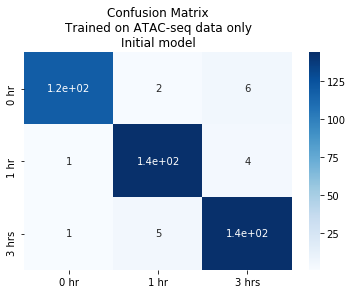

In [152]:
make_confusion_matrix_DEX(Y_atac_test, y_atac_pred, subtitle='Trained on ATAC-seq data only\nInitial model')

In [153]:
''' Evaluate model trained ONLY on RNA-seq input '''
y_rna_pred = predict_one_hot(X_rna_test, model_dir='models/best_rna_model')
y_rna_sm = predict(X_rna_test, model_dir='models/best_rna_model')

In [154]:
''' Get metrics for RNA-seq'''
print(f'Accuracy: {accuracy(Y_rna_test, y_rna_pred)}')
print(f'Precision: {precision(Y_rna_test, y_rna_pred)}')
print(f'Recall: {precision(Y_rna_test, y_rna_pred)}')

Accuracy: 0.9735202789306641
Precision: 0.9602803587913513
Recall: 0.9602803587913513


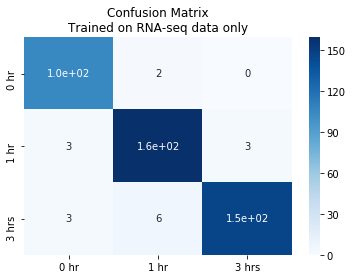

In [155]:
make_confusion_matrix_DEX(Y_rna_test, y_rna_pred, subtitle='Trained on RNA-seq data only')

In [156]:
''' Evaluate model trained on bimodal input (concatenation of ATAC + RNA) '''
y_bimodal_pred = predict_one_hot(X_bimodal_test, model_dir='models/best_bimodal_model')
y_bimodal_sm = predict(X_bimodal_test, model_dir='models/best_bimodal_model')

In [157]:
''' Get metrics using bimodal input '''
print(f'Accuracy: {accuracy(Y_bimodal_test, y_bimodal_pred)}')
print(f'Precision: {precision(Y_bimodal_test, y_bimodal_pred)}')
print(f'Recall: {precision(Y_bimodal_test, y_bimodal_pred)}')

Accuracy: 0.9754601120948792
Precision: 0.9631901979446411
Recall: 0.9631901979446411


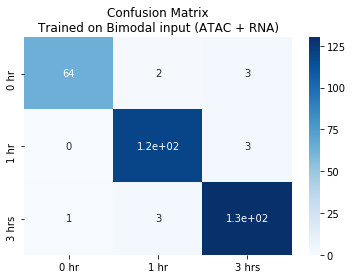

In [158]:
make_confusion_matrix_DEX(Y_bimodal_test, y_bimodal_pred, subtitle='Trained on Bimodal input (ATAC + RNA)')